### Preliminary Wrangling

In [142]:
#install sqlalchemy
# !pip install sqlalchemy 

In [143]:
#import the needed libraries
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine, text

In [144]:
# load the csv file into a pandas dataframe

car_sharing = pd.read_csv('CarSharing.csv')

In [145]:
car_sharing.head() #preview the data

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


In [146]:
car_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8708 non-null   int64  
 1   timestamp   8708 non-null   object 
 2   season      8708 non-null   object 
 3   holiday     8708 non-null   object 
 4   workingday  8708 non-null   object 
 5   weather     8708 non-null   object 
 6   temp        7506 non-null   float64
 7   temp_feel   8606 non-null   float64
 8   humidity    8669 non-null   float64
 9   windspeed   8508 non-null   float64
 10  demand      8708 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 748.5+ KB


In [147]:
car_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8708 non-null   int64  
 1   timestamp   8708 non-null   object 
 2   season      8708 non-null   object 
 3   holiday     8708 non-null   object 
 4   workingday  8708 non-null   object 
 5   weather     8708 non-null   object 
 6   temp        7506 non-null   float64
 7   temp_feel   8606 non-null   float64
 8   humidity    8669 non-null   float64
 9   windspeed   8508 non-null   float64
 10  demand      8708 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 748.5+ KB


### __Data Management Tasks__
1. Create an SQLite database and import the data into a table named “CarSharing”. Create a backup table and copy the whole table into it

In [148]:
# create the SQLite database engine
engine = create_engine('sqlite:///car_share.db')

# import the dataframe into the SQLite database
car_sharing.to_sql('CarSharing', engine, index=False, if_exists = 'replace')

8708

In [149]:
# copy the data into a backup table in the database

with engine.connect() as conn:
    conn.execute('''CREATE TABLE CarSharing_copy AS
                    SELECT *                            
                    FROM CarSharing''')

2. Add a column to the CarSharing table named “temp_category”. 

> This column should contain three string values. 

- If the “feels-like” temperature is less than 10 then the corresponding value in the temp_category column should be “Cold” 
- If the feels-like temperature is between 10 and 25, the value should be “Mild”, and 
- If the feels-like temperature is greater than 25, then the value should be “Hot”.

In [150]:
# add column to CarSharing called temp_category
with engine.connect() as conn:
    conn.execute('''ALTER TABLE CarSharing 
                    ADD COLUMN temp_category VARCHAR(255)''')
    
    #set value categories to different temp_feel ranges
    conn.execute('''UPDATE CarSharing 
                    SET temp_category = CASE WHEN temp_feel < 10 THEN 'Cold' 
                    WHEN temp_feel BETWEEN 10 AND 25 THEN 'Mild' 
                    ELSE 'Hot' END''')

3. Create another table named “temperature” by selecting the temp, temp_feel, and temp_category columns. 
Then drop the temp and temp_feel columns from the CarSharing
table.

In [151]:
with engine.connect() as conn:
    # create a new table 'temperature' with only the columns temp, temp_feel, and temp_category
    conn.execute('''CREATE TABLE temperature AS
                    SELECT temp, temp_feel, temp_category
                    FROM CarSharing''')

In [152]:
with engine.connect() as conn:
    # drop the temp column
    conn.execute('''ALTER TABLE CarSharing
                    DROP COLUMN temp;''')

with engine.connect() as conn:
    # drop the temp_feel column
    conn.execute('''ALTER TABLE CarSharing
                    DROP COLUMN temp_feel''')

4. Find the distinct values of the weather column and assign a number to each value. 

> Add another column named “weather_code” to the table containing each row’s assigned weather code. 

In [153]:
with engine.connect() as conn:
    # add the weather code column to the table
    conn.execute('''ALTER TABLE CarSharing
                    ADD COLUMN weather_code
                     ''')
    # find the distinct values in the weather column and add that values to the table
    conn.execute('''WITH sub_query AS (
                                        SELECT weather, ROW_NUMBER() OVER(ORDER BY weather) weather_code
                                        FROM (
                                                SELECT DISTINCT weather
                                                FROM CarSharing)
                                        )
                                       
                    UPDATE CarSharing
                    SET weather_code = sub_query.weather_code
                    FROM sub_query
                    WHERE CarSharing.weather = sub_query.weather
                    ''')

5. Create a table called “weather” and copy the columns “weather” and “weather_code” to this table. 

Then drop the weather column from the CarSharing table. 

In [154]:
with engine.connect() as conn:
    
    # create the table weather and its columns
    conn.execute('''CREATE TABLE weather AS 
                    SELECT weather, weather_code
                    FROM CarSharing
                ''')
    
    # copy the values from CarSharing table into the weather table
    conn.execute('''ALTER TABLE CarSharing
                    DROP COLUMN weather
                    ''')

6. Create a table called time with four columns containing each row’s timestamp, hour, weekday name, and month name 

In [155]:
with engine.connect() as conn:
    conn.execute('''CREATE TABLE time AS
                    SELECT strftime("%Y-%m-%d %H:%M:%S", timestamp) timestamp, strftime("%H", timestamp) hour, CASE CAST(strftime("%w", timestamp) AS INTEGER)
                                                                                                                        WHEN 0 THEN "Sunday"
                                                                                                                        WHEN 1 THEN "Monday"
                                                                                                                        WHEN 2 THEN "Tuesday"
                                                                                                                        WHEN 3 THEN "Wednesday"
                                                                                                                        WHEN 4 THEN "Thrusday"
                                                                                                                        WHEN 5 THEN "Friday"
                                                                                                                        ELSE "Saturday" END AS day_name, CASE CAST(strftime("%m", timestamp) AS INTEGER)
                                                                                                                                                         WHEN 1 THEN "January"
                                                                                                                                                         WHEN 2 THEN "February"
                                                                                                                                                         WHEN 3 THEN "March"
                                                                                                                                                         WHEN 4 THEN "April"
                                                                                                                                                         WHEN 5 THEN "May"
                                                                                                                                                         WHEN 6 THEN "June"
                                                                                                                                                         WHEN 7 THEN "July"
                                                                                                                                                         WHEN 8 THEN "August"
                                                                                                                                                         WHEN 9 THEN "September"
                                                                                                                                                         WHEN 10 THEN "October"
                                                                                                                                                         WHEN 11 THEN "November"
                                                                                                                                                         WHEN 12 THEN "December" END AS month_name
                    FROM CarSharing''')

7. Assume it’s the first day you have started working at this company and your boss Linda sends you an email as follows:


“Hello, Welcome to the team. I hope you enjoy working at this company.

Could you please give me a report containing the following information:

a. Please tell me which date and time we had the highest demand rate in 2017.

In [156]:
# which date and time we had the highest demand rate in 2017
with engine.connect() as conn:
    result = conn.execute('''SELECT timestamp, MAX(demand) demand
                    FROM CarSharing
                    WHERE timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                    ''')
    df = pd.DataFrame(result)
    print(df)

             timestamp    demand
0  2017-06-15 17:00:00  6.458338


b.  Give me a table containing the name of the weekday, month, and season in which we had the highest and lowest average demand rates throughout 2017. Please include the calculated average demand values as well. 

In [157]:
with engine.connect() as conn:
    result = conn.execute('''WITH avg_demand AS (SELECT t.day_name, t.month_name, c.season, AVG(c.demand) avg_demand
                                            FROM CarSharing c
                                            JOIN time t
                                            ON c.timestamp = t.timestamp
                                            WHERE t.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                                            GROUP BY 1,2,3
                                            ORDER BY 4 DESC
                                            )
                            
                             SELECT av.day_name, av.month_name, av.season, av.avg_demand
                             FROM avg_demand av
                             WHERE av.avg_demand = (SELECT MIN(av.avg_demand)
                                                     FROM avg_demand av) OR av.avg_demand = (SELECT MAX(av.avg_demand)
                                                                                             FROM avg_demand av)
                             ORDER BY 4 
                             
                            ''')
    df = pd.DataFrame(result)
    print(df)

  day_name month_name  season  avg_demand
0   Monday    January  spring    3.050786
1   Sunday       July    fall    4.997135


c. For the weekday selected in (b), please give me a table showing the average demand rate we had at different hours of that weekday throughout 2017. Please sort the results in descending order based on the average demand rates. 

In [158]:
with engine.connect() as conn:
    result = conn.execute('''WITH avg_demand AS (SELECT t.day_name, t.month_name, c.season, AVG(c.demand) avg_demand
                                            FROM CarSharing c
                                            JOIN time t
                                            ON c.timestamp = t.timestamp
                                            WHERE t.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                                            GROUP BY 1,2,3
                                            ORDER BY 4 DESC
                                            ),
                            
                             min_max AS (SELECT av.day_name, av.month_name, av.season, av.avg_demand
                             FROM avg_demand av
                             WHERE av.avg_demand = (SELECT MIN(av.avg_demand)
                                                     FROM avg_demand av) OR av.avg_demand = (SELECT MAX(av.avg_demand)
                                                                                             FROM avg_demand av)
                             ORDER BY 4), 
                             
                             min_max_day AS (SELECT day_name
                                             FROM min_max)
                             
                            SELECT t.hour, t.day_name, AVG(c.demand) avg_demand
                            FROM CarSharing c
                            JOIN time t
                            ON c.timestamp = t.timestamp 
                            WHERE t.day_name IN min_max_day AND c.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                            GROUP BY 1,2
                            ORDER BY 3 DESC
                            ''')
    df = pd.DataFrame(result)
    print(df)

   hour day_name  avg_demand
0    13   Monday    5.643554
1    12   Monday    5.621972
2    14   Monday    5.554613
3    15   Sunday    5.537925
4    15   Monday    5.515115
5    14   Sunday    5.513703
6    16   Monday    5.503753
7    16   Sunday    5.496274
8    13   Sunday    5.478758
9    12   Sunday    5.457459
10   11   Monday    5.437365
11   17   Monday    5.399252
12   17   Sunday    5.367634
13   11   Sunday    5.290915
14   18   Sunday    5.241212
15   10   Monday    5.223831
16   18   Monday    5.215943
17   10   Sunday    5.074546
18   19   Sunday    5.041802
19   19   Monday    4.990500
20   20   Sunday    4.790666
21   20   Monday    4.726986
22   09   Sunday    4.683176
23   09   Monday    4.638345
24   21   Sunday    4.604222
25   22   Sunday    4.477620
26   21   Monday    4.464856
27   23   Sunday    4.346754
28   00   Monday    4.230482
29   08   Sunday    4.204916
30   22   Monday    4.188675
31   00   Sunday    4.134974
32   01   Monday    3.976929
33   08   Mond

d. Please tell me what the weather was like in 2017. Was it mostly cold, mild, or hot?

- Which weather condition (shown in the weather column) was the most prevalent in 2017? 

- What was the average, highest, and lowest wind speed and humidity for each month in 2017? 

Please organise this information in two tables for the wind speed and humidity. 

- Please also give me a table showing the average demand rate for each cold, mild, and hot weather in 2017 sorted in descending order based on their average demand rates. 

In [159]:
with engine.connect() as conn:
    result = conn.execute('''SELECT w.weather, COUNT(*) count
                            FROM weather  w
                            JOIN CarSharing c
                            ON w.weather_code = c.weather_code AND c.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                            GROUP BY 1
                            ORDER BY 2 DESC
                            
                            ''')
    df = pd.DataFrame(result)
    print(df)

                  weather     count
0  Clear or partly cloudy  20989214
1                    Mist   2925972
2      Light snow or rain    334411


In [160]:
with engine.connect() as conn:
    wind_result = conn.execute('''SELECT t.month_name, AVG(c.windspeed) avg_windspeed, MIN(c.windspeed) min_windspeed, MAX(c.windspeed) max_windspeed
                            FROM CarSharing c
                            JOIN time t
                            ON t.timestamp = c.timestamp AND t.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                            GROUP BY 1
                            ''')
    humidity_result = conn.execute('''SELECT t.month_name, AVG(c. humidity) avg_humidity, MIN(c. humidity) min_humidity, MAX(c. humidity) max_humidity
                                    FROM CarSharing c
                                    JOIN time t
                                    ON t.timestamp = c.timestamp AND t.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                                    GROUP BY 1
                                    ''')
    df1 = pd.DataFrame(wind_result)
    df2 = pd.DataFrame(humidity_result)
    print(df1)
    print('\n')
    print(df2)

   month_name  avg_windspeed  min_windspeed  max_windspeed
0       April      15.852275            0.0        40.9973
1      August      12.411122            0.0        43.0006
2    December      10.836460            0.0        43.0006
3    February      15.577717            0.0        51.9987
4     January      13.748052            0.0        39.0007
5        July      12.015846            0.0        56.9969
6        June      11.827618            0.0        35.0008
7       March      15.974884            0.0        40.9973
8         May      12.427391            0.0        40.9973
9    November      12.142271            0.0        36.9974
10    October      10.892052            0.0        36.9974
11  September      11.564080            0.0        40.9973


   month_name  avg_humidity  min_humidity  max_humidity
0       April     66.248899          22.0         100.0
1      August     62.173626          25.0          94.0
2    December     65.180617          26.0         100.0
3    Fe

In [161]:
with engine.connect() as conn:
    result = conn.execute('''SELECT temp_category, AVG(demand) avg_demand
                            FROM CarSharing 
                            WHERE timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                            GROUP BY 1
                            ORDER BY 2 DESC
                        ''')
    df = pd.DataFrame(result)
    print(df.head())

  temp_category  avg_demand
0           Hot    4.774353
1          Mild    4.021015
2          Cold    3.190253


e. Give me another table showing the information requested in (d) for the month we had the highest average demand rate in 2017 so that I can compare it with other months

In [162]:
with engine.connect() as conn:
    result = conn.execute('''WITH monthly_demand AS (SELECT  strftime('%m', timestamp) month, AVG(demand) avg_demand
                                                     FROM CarSharing 
                                                     WHERE timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                                                     GROUP BY 1
                                                     )
                            
                            SELECT w.weather, COUNT(*) count
                            FROM weather  w
                            JOIN CarSharing c
                            ON w.weather_code = c.weather_code AND c.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                            WHERE strftime('%m', timestamp) = (SELECT month
                                                   FROM monthly_demand
                                                   WHERE avg_demand = (SELECT MAX(avg_demand)
                                                                       FROM monthly_demand)
                                                    )
                            GROUP BY 1
                            ORDER BY 2 DESC                   
                        ''')
    df = pd.DataFrame(result)
    print(df.head())

                  weather    count
0  Clear or partly cloudy  2261188
1                    Mist   119952
2      Light snow or rain     9898


In [163]:
with engine.connect() as conn:
    wind_result = conn.execute('''WITH monthly_demand AS (SELECT  strftime('%m', timestamp) month, AVG(demand) avg_demand
                                                     FROM CarSharing 
                                                     WHERE timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                                                     GROUP BY 1
                                                     )
                            
                            SELECT t.month_name, AVG(c.windspeed) avg_windspeed, MIN(c.windspeed) min_windspeed, MAX(c.windspeed) max_windspeed
                            FROM CarSharing c
                            JOIN time t
                            ON t.timestamp = c.timestamp AND t.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                            WHERE strftime('%m', t.timestamp) = (SELECT month
                                                               FROM monthly_demand
                                                               WHERE avg_demand = (SELECT MAX(avg_demand)
                                                                                   FROM monthly_demand)
                                                                )
                            GROUP BY 1
                            
                                      
                        ''')
    df = pd.DataFrame(wind_result)
    print(df)

  month_name  avg_windspeed  min_windspeed  max_windspeed
0       July      12.015846            0.0        56.9969


In [164]:
with engine.connect() as conn:
    wind_result = conn.execute('''WITH monthly_demand AS (SELECT  strftime('%m', timestamp) month, AVG(demand) avg_demand
                                                     FROM CarSharing 
                                                     WHERE timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                                                     GROUP BY 1
                                                     )
                            
                            SELECT t.month_name, AVG(c. humidity) avg_humidity, MIN(c. humidity) min_humidity, MAX(c. humidity) max_humidity
                            FROM CarSharing c
                            JOIN time t
                            ON t.timestamp = c.timestamp AND t.timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                            WHERE strftime('%m', t.timestamp) = (SELECT month
                                                               FROM monthly_demand
                                                               WHERE avg_demand = (SELECT MAX(avg_demand)
                                                                                   FROM monthly_demand)
                                                                )
                            GROUP BY 1
                            
                                      
                        ''')
    df = pd.DataFrame(wind_result)
    print(df)

  month_name  avg_humidity  min_humidity  max_humidity
0       July     60.292035          17.0          94.0


In [165]:
with engine.connect() as conn:
    result = conn.execute('''WITH monthly_demand AS (SELECT  strftime('%m', timestamp) month, AVG(demand) avg_demand
                                                     FROM CarSharing 
                                                     WHERE timestamp BETWEEN '2017-01-01' AND '2017-12-31'
                                                     GROUP BY 1
                                                     )
                                                     
                            SELECT temp_category, AVG(demand) avg_demand
                            FROM CarSharing 
                            WHERE timestamp BETWEEN '2017-01-01' AND '2017-12-31' AND strftime('%m', timestamp) = (SELECT month
                                                                                                                   FROM monthly_demand
                                                                                                                   WHERE avg_demand = (SELECT MAX(avg_demand)
                                                                                                                                       FROM monthly_demand)
                                                                                                                    )
                            GROUP BY 1
                            ORDER BY 2 DESC
                        ''')
    df = pd.DataFrame(result)
    print(df.head())

  temp_category  avg_demand
0           Hot    4.787655


### Data Analytics

In [2]:
# import the necessary packages and libraries
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.tsa.seasonal import seasonal_decompose

1. Import the CarSharing table into a CSV file and preprocess it with python. 
>You need to drop duplicate rows and deal with null values using appropriate methods.


In [ ]:
# save the CarSharing table from our database to a csv file
with engine.connect() as conn:
    df = pd.read_sql_query('SELECT * FROM CarSharing', conn)
    df.to_csv('car_sharing.csv', index=False)

In [3]:
# import the CarSharing table as a pandas dataframe

df = pd.read_csv('car_sharing.csv')
df.head()

,id,timestamp,season,holiday,workingday,humidity,windspeed,demand,temp_category,weather_code
0,1,2017-01-01 00:00:00,spring,No,No,81.0,0.0,2.772589,Mild,1
1,2,2017-01-01 01:00:00,spring,No,No,80.0,0.0,3.688879,Mild,1
2,3,2017-01-01 02:00:00,spring,No,No,80.0,0.0,3.465736,Mild,1
3,4,2017-01-01 03:00:00,spring,No,No,75.0,0.0,2.564949,Mild,1
4,5,2017-01-01 04:00:00,spring,No,No,75.0,0.0,0.000000,Mild,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8708 non-null   int64  
 1   timestamp      8708 non-null   object 
 2   season         8708 non-null   object 
 3   holiday        8708 non-null   object 
 4   workingday     8708 non-null   object 
 5   humidity       8669 non-null   float64
 6   windspeed      8508 non-null   float64
 7   demand         8708 non-null   float64
 8   temp_category  8708 non-null   object 
 9   weather_code   8708 non-null   int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 680.4+ KB


In [4]:
# convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df.timestamp)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             8708 non-null   int64         
 1   timestamp      8708 non-null   datetime64[ns]
 2   season         8708 non-null   object        
 3   holiday        8708 non-null   object        
 4   workingday     8708 non-null   object        
 5   humidity       8669 non-null   float64       
 6   windspeed      8508 non-null   float64       
 7   demand         8708 non-null   float64       
 8   temp_category  8708 non-null   object        
 9   weather_code   8708 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 680.4+ KB


In [5]:
# check for duplicate and null rows 
print('Duplucated: %s' % df.duplicated().any())
print('\n')
print(df.isna().any())

Duplucated: False


id               False
timestamp        False
season           False
holiday          False
workingday       False
humidity          True
windspeed         True
demand           False
temp_category    False
weather_code     False
dtype: bool


In [6]:
# preview the null columns in the dataframe

df.isnull().sum()

id                 0
timestamp          0
season             0
holiday            0
workingday         0
humidity          39
windspeed        200
demand             0
temp_category      0
weather_code       0
dtype: int64

In [7]:
# preview the discriptive statistics of those Null columns
df[['humidity', 'windspeed']].describe()

,humidity,windspeed
count,8669.00000,8508.000000
mean,60.99354,13.048589
std,19.67989,8.311058
min,0.00000,0.000000
25%,46.00000,7.001500
50%,60.00000,12.998000
75%,77.00000,19.001200
max,100.00000,56.996900


In [8]:
# obtain the mean of both columns with null values

windspeed_mean = df.windspeed.mean()
humidity_mean = df.humidity.mean()

# fill the null values with the mean of the columns 

df.windspeed.fillna(windspeed_mean, inplace=True)
df.humidity.fillna(humidity_mean, inplace=True)

# check for null values in the df
df.isna().any()

id               False
timestamp        False
season           False
holiday          False
workingday       False
humidity         False
windspeed        False
demand           False
temp_category    False
weather_code     False
dtype: bool

In [9]:
df.head()

,id,timestamp,season,holiday,workingday,humidity,windspeed,demand,temp_category,weather_code
0,1,2017-01-01 00:00:00,spring,No,No,81.0,0.0,2.772589,Mild,1
1,2,2017-01-01 01:00:00,spring,No,No,80.0,0.0,3.688879,Mild,1
2,3,2017-01-01 02:00:00,spring,No,No,80.0,0.0,3.465736,Mild,1
3,4,2017-01-01 03:00:00,spring,No,No,75.0,0.0,2.564949,Mild,1
4,5,2017-01-01 04:00:00,spring,No,No,75.0,0.0,0.000000,Mild,1


2. Using appropriate hypothesis testing, determine if there is a significant relationship between each column (except the timestamp column) and the demand rate. 

> Report the tests’ results. 

In [11]:
# write functions to repeat this analysis for all the columns
def anova_test(df,predictor,outcome='demand'):
    '''Runs an ANOVA on a pandas dataframe using the output variable and a categorical predictor column
    Data types:
    - predictor should be of categorical data type
    - outcome variable should be of quantitative data type
    Returns:
    And anova table showing the details of test result'''
    formula = f"{outcome} ~ C({predictor})"
    model = ols(formula, data=df).fit()
    anova_table = anova_lm(model)
    
    'Print the result of the ANOVA test showing the F-statistic and the p_value as PR(>F)'
    print(f'\tANOVA test for {predictor} and demand\n') 
    print(anova_table[['F','PR(>F)']].iloc[0])


def corr_test(df,predictor,outcome='demand'):
    '''Runs a pearsons correlation test on two continuous columns of the dataframe
    Use: 
    Test the relation between quantitative variables 
    Returns:
    2 values: the correlation coefficient and the p value from the test'''
    corr, p_value = pearsonr(df[predictor], df[outcome])
    
    'Print results of the correlation test showing the correlation coefficient and p_value'
    print(f'\tCorrelation test for {predictor} and demand\n')
    print(f"Correlation coefficient: {corr} \np_value: {p_value}")

In [12]:
# season vs demand

anova_test(df,'season')

	ANOVA test for season and demand

F         1.500648e+02
PR(>F)    8.024922e-95
Name: C(season), dtype: float64


In [25]:
# holiday vs demand

anova_test(df,'holiday')

	ANOVA test for holiday and demand

F         0.011054
PR(>F)    0.916267
Name: C(holiday), dtype: float64


In [26]:
# workingday vs demand

anova_test(df,'workingday')

	ANOVA test for workingday and demand

F         2.868367
PR(>F)    0.090372
Name: C(workingday), dtype: float64


In [27]:
# humidity vs windspeed

corr_test(df,'humidity')

	Correlation test for humidity and demand

Correlation coefficient: -0.3307919138439357 
p_value: 2.1447286875685434e-221


In [28]:
# windspeed vs demand

corr_test(df,'windspeed')

	Correlation test for windspeed and demand

Correlation coefficient: 0.11831270842838336 
p_value: 1.606146300078552e-28


In [29]:
# temp_category vs demand

anova_test(df,'temp_category')

	ANOVA test for temp_category and demand

F          5.231823e+02
PR(>F)    2.731920e-215
Name: C(temp_category), dtype: float64


In [31]:
# weather_code vs demand

anova_test(df,'weather_code')

	ANOVA test for weather_code and demand

F         4.858619e+01
PR(>F)    3.927930e-31
Name: C(weather_code), dtype: float64


The null hypothesis is that there is no relationship between values in each of the columns and the demand column. The alternative hypothesis is the opposite where a relationship exists between the values of the columns and the demand column.

> The `season`, `humidity`, `windspeed`, `temp_category`, and `weather_code` columns had very small p-values (<0.05) following the test. Hence, we reject the null hypothesis for these cases.

This implies that there are significant differences between the groups in each of these columns. 

- More importantly, this strongly indicates that the categories within these columns influence the outcome variable

On the other hand, `holiday` and `workingday` had higher p-values indicating support for the Null hypothesis that no significant difference exists between the categories in those variables

> Hence we do not reject the null hypothesis for these cases

3. Please describe if you see any seasonal or cyclic pattern in the temp, humidity, windspeed, or demand data in 2017. >

> Describe your answers. 

In [13]:
# use seasonal decomposition to check for seasonality or patterns in the data
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
# use a test column - humidity to check for seasonality 
# make the timestamp column the index
df.head()

,id,timestamp,season,holiday,workingday,humidity,windspeed,demand,temp_category,weather_code
0,1,2017-01-01 00:00:00,spring,No,No,81.0,0.0,2.772589,Mild,1
1,2,2017-01-01 01:00:00,spring,No,No,80.0,0.0,3.688879,Mild,1
2,3,2017-01-01 02:00:00,spring,No,No,80.0,0.0,3.465736,Mild,1
3,4,2017-01-01 03:00:00,spring,No,No,75.0,0.0,2.564949,Mild,1
4,5,2017-01-01 04:00:00,spring,No,No,75.0,0.0,0.000000,Mild,1


In [62]:
# set the index of the dataframe to be the timestamp
df_season = df.copy()
df_season = df.set_index('timestamp')
df_season.head()

,id,season,holiday,workingday,humidity,windspeed,demand,temp_category,weather_code
timestamp,,,,,,,,,
2017-01-01 00:00:00,1,spring,No,No,81.0,0.0,2.772589,Mild,1
2017-01-01 01:00:00,2,spring,No,No,80.0,0.0,3.688879,Mild,1
2017-01-01 02:00:00,3,spring,No,No,80.0,0.0,3.465736,Mild,1
2017-01-01 03:00:00,4,spring,No,No,75.0,0.0,2.564949,Mild,1
2017-01-01 04:00:00,5,spring,No,No,75.0,0.0,0.000000,Mild,1


In [65]:
# set the frequency of the index to be hourly as in the dataframe
df_season = df_season.asfreq('H')
print(df_season.index.freq)

<Hour>


In [87]:
# inspect columns with null values
df_season.isna().sum()

id               5241
season           5241
holiday          5241
workingday       5241
humidity         5241
windspeed        5241
demand           5241
temp_category    5241
weather_code     5241
dtype: int64

In [88]:
# difference between newly added rows in the df_season and the original df
df_season.shape[0] - df.shape[0]

5241

In [90]:
# drop rows with null values
df_season.dropna(inplace=True,how='all')
df_season.isna().sum()

id               0
season           0
holiday          0
workingday       0
humidity         0
windspeed        0
demand           0
temp_category    0
weather_code     0
dtype: int64

In [100]:
assert df_season.shape[0] == df.shape[0]

In [41]:
# define the function to perform the seasonal decompose on the various columns in the df
def decompose(df, column, period=7):
#     resample the data to weekly averages to reduce noise in the data
    new_df = df.resample('W').mean().dropna(how='all')
    analysis = new_df[column]
    
    # perform the seasonal decompostion on the new df - analysis
    seasonal_decompose_result = seasonal_decompose(x=analysis, period=period)
    
    trend = seasonal_decompose_result.trend
    seasonal = seasonal_decompose_result.seasonal
    residual = seasonal_decompose_result.resid
    
    return seasonal_decompose_result.plot();

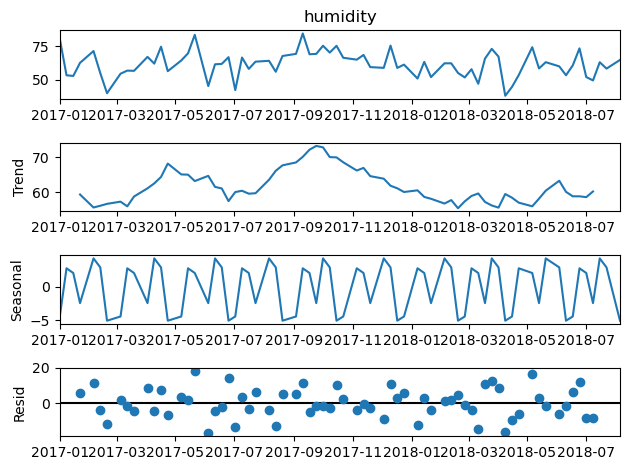

In [42]:
# seasonal decomposition on humidity column
decompose(df_season,'humidity', period=7);

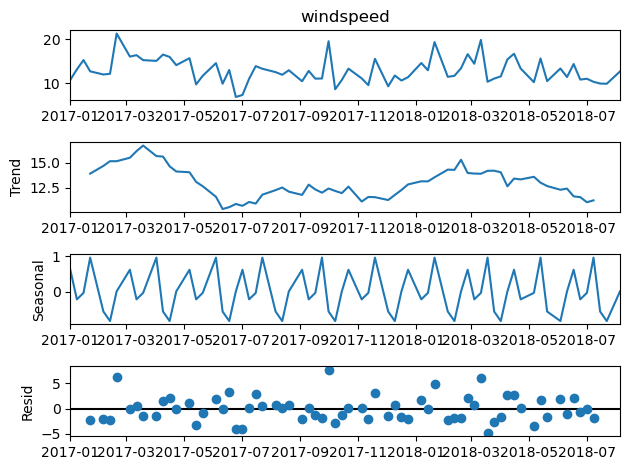

In [43]:
# seasonal decomposition on windspeed
decompose(df_season, 'windspeed', period=7);

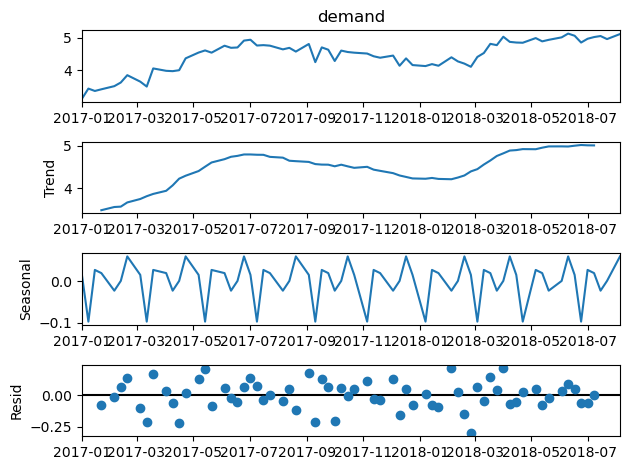

In [44]:
# seasonal decomposition on demand
decompose(df_season, 'demand');

> The seasonal decompositions show that there is seasonality in the data as there are repetitive patterns observed

These seasonality and cyclic patterns are easily observed on a __weekly__ average breakdown of the data

4. Use an ARIMA model to predict the weekly average demand rate. Consider 30 percent of data for testing.

In [15]:
# import ARIMA model and evaluation metrics

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# get the weekly average demand
arima_df = df.set_index('timestamp')
arima_df = arima_df.resample('W').mean()
arima_df.dropna(inplace=True, how='all')

# split the data into training and test sets
train_size = int(0.7*len(arima_df))  # calculate the training data size

train_data = arima_df.iloc[:train_size].demand.values
test_data = arima_df.iloc[train_size:].demand.values

In [17]:
# build the arima model

model = ARIMA(train_data, order=(2,2,2))

In [18]:
result = model.fit() # fit the model

In [32]:
# make predictions for the next points using the shape of the test set
preds = result.predict(start=int(train_data.shape[0])+1, end=int(test_data.shape[0])+int(train_data.shape[0])) 

In [33]:
print('Mean squared error: %.2f' % mean_squared_error(test_data, preds))
print('R squared score: %.2f ' % r2_score(test_data, preds))

Mean squared error: 0.07
R squared score: -0.16 


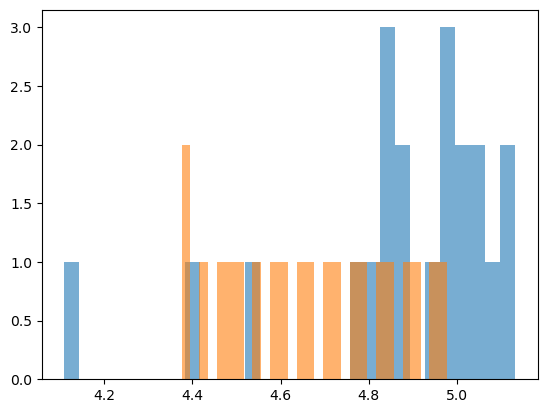

In [135]:
plt.hist(test_data, bins =30, alpha=0.6)
plt.hist(preds, bins =30, alpha=0.6);

The negative R-squared score and the relatively high MSE suggest that the model is not capturing the underlying patterns or relationships in the data accurately.This could be due to several reasons such as underfitting, inappropriate choice of features, or insufficient data.

5. Use a random forest regressor and a deep neural network to predict the demand rate and report the minimum square error for each model. Which one is working better? Why? Please describe the reason.

In [9]:
# for the randomforest algorithm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

#### Preprocessing the data

In [12]:
df.shape

(8708, 10)

In [13]:
df.head()

,id,timestamp,season,holiday,workingday,humidity,windspeed,demand,temp_category,weather_code
0,1,2017-01-01 00:00:00,spring,No,No,81.0,0.0,2.772589,Mild,1
1,2,2017-01-01 01:00:00,spring,No,No,80.0,0.0,3.688879,Mild,1
2,3,2017-01-01 02:00:00,spring,No,No,80.0,0.0,3.465736,Mild,1
3,4,2017-01-01 03:00:00,spring,No,No,75.0,0.0,2.564949,Mild,1
4,5,2017-01-01 04:00:00,spring,No,No,75.0,0.0,0.000000,Mild,1


In [10]:
# change the datatype of weather_code attribute to categorical data type

df.weather_code = df.weather_code.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             8708 non-null   int64         
 1   timestamp      8708 non-null   datetime64[ns]
 2   season         8708 non-null   object        
 3   holiday        8708 non-null   object        
 4   workingday     8708 non-null   object        
 5   humidity       8708 non-null   float64       
 6   windspeed      8708 non-null   float64       
 7   demand         8708 non-null   float64       
 8   temp_category  8708 non-null   object        
 9   weather_code   8708 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 621.1+ KB


In [10]:
predictors = ['season', 'humidity', 'windspeed', 'temp_category', 'weather_code']

X_df = df[predictors]

In [15]:
obj_column = ['season', 'temp_category', 'weather_code']

# loop through the list to get dummies for each column
for item in obj_column:
    X_new = pd.get_dummies(df[item])
    X_df = pd.concat([X_df, X_new], axis=1)

X_df = X_df.drop(columns=obj_column)
X_df.rename(columns = {1:'one', 2:'two', 3:'three', 4:'four'}, inplace=True)
X_df.head()

,humidity,windspeed,fall,spring,summer,winter,Cold,Hot,Mild,one,two,three,four
0,81.0,0.0,0,1,0,0,0,0,1,1,0,0,0
1,80.0,0.0,0,1,0,0,0,0,1,1,0,0,0
2,80.0,0.0,0,1,0,0,0,0,1,1,0,0,0
3,75.0,0.0,0,1,0,0,0,0,1,1,0,0,0
4,75.0,0.0,0,1,0,0,0,0,1,1,0,0,0


In [16]:
X = X_df.values
y = df.demand.values

# split the data with 30% as test set
train_size = int(0.7*df.shape[0])
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6095, 13) (6095,)
(2613, 13) (2613,)


In [44]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [45]:
predictions = forest_model.predict(X_test)

In [48]:
print('Mean squared error: %.2f' % mean_squared_error(y_test, predictions))
print('Mean absolute error: %.2f' % mean_absolute_error(y_test, predictions))

Mean squared error: 2.22
Mean absolute error: 1.16


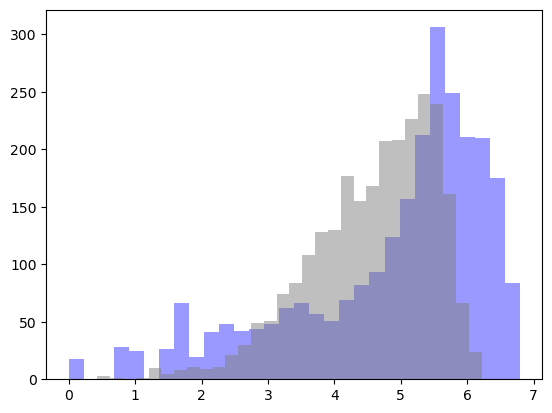

In [63]:
plt.hist(y_test, bins =30, alpha=0.4, color='blue')
plt.hist(predictions, bins =30, alpha=0.5, color='grey');

In [138]:
!pip install keras

     ---------------------------------------- 1.7/1.7 MB 340.2 kB/s eta 0:00:00


In [1]:
!pip install tensorflow

In [64]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [65]:
# reshape the data set for suitability with the deep learning model

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('Train set')
print(X_train.shape, y_train.shape)

print()
print('Test set')
print(X_test.shape, y_test.shape)

Train set
(6095, 1, 13) (6095,)

Test set
(2613, 1, 13) (2613,)


In [108]:
# build the layers of the RNN model (GRU)
gru_model = Sequential()
gru_model.add(GRU(units=20, activation='relu', input_shape=(1, X.shape[1]))) # one input layer and one hidden layer
gru_model.add(Dense(units=1)) #output layer

# specify how the data should be compiled
gru_model.compile(optimizer='adam', loss='mean_squared_error')

In [109]:
def train_model():
    gru_model.fit(X_train, y_train, epochs=50, batch_size=32)

train_model()

Epoch 1/50
191/191 [==============================] - 2s 2ms/step - loss: 3.7326
Epoch 2/50
191/191 [==============================] - 0s 2ms/step - loss: 1.7812
Epoch 3/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6819
Epoch 4/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6713
Epoch 5/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6990
Epoch 6/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6727
Epoch 7/50
191/191 [==============================] - 0s 3ms/step - loss: 1.6654
Epoch 8/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6683
Epoch 9/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6651
Epoch 10/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6572
Epoch 11/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6658
Epoch 12/50
191/191 [==============================] - 0s 2ms/step - loss: 1.6625
Epoch 13/50
191/191 [====

In [110]:
predictions = gru_model.predict(X_test)
predictions

82/82 [==============================] - 0s 2ms/step


array([[4.3520565],
       [3.2591062],
       [3.93645  ],
       ...,
       [4.998337 ],
       [4.6697073],
       [4.6697073]], dtype=float32)

In [111]:
print('Mean squared error: %.2f' % mean_squared_error(y_test, predictions))
print('Mean absolute error: %.2f' % mean_absolute_error(y_test, predictions))

Mean squared error: 1.73
Mean absolute error: 1.01


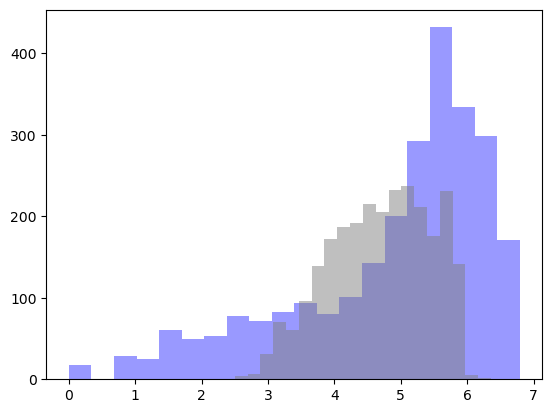

In [112]:
plt.hist(y_test, bins =20, alpha=0.4, color='blue')
plt.hist(predictions, bins =20, alpha=0.5, color='grey');

#### Which model between the Random Froest and Deep Learning works better and why?

> The Deep learing model works better than the Random forest model in predicting demand due to a number of vital reasons associated with each model's design

The following metrics show that the Random forest model performed poorer than the GRU model upon evaluation.

__Random Forest Model__

```Mean squared error: 2.22```

```Mean absolute error: 1.16 ```
 
__GRU Model__

```Mean squared error: 1.73```

```Mean absolute error: 1.01```

The GRU model is a type of recurrent neural network (RNN) specifically designed to capture sequential dependencies in data. 

It can effectively model temporal patterns and capture long-term dependencies in time series data. This architecture makes it more suitable for the specific time series problem worked on. Thus, allowing it to capture and leverage the underlying patterns in the data better than the Random Forest model.

Also, the GRU model was compiled to minimize the mean squared error (MSE). Hence, from training it is better suited to make predictions that result in lower MSE than the random forest which only learnt the underlying patterns of the data.

.

6- Categorize the demand rate into the following two groups: demand rates greater than the average demand rate and demand rates less than the average demand rate. Use labels 1 and 2 for the first and the second groups, respectively. 

Now, use three different classifiers to predict the demand rates’ labels and report the accuracy of all models. Use 30 percent of data for testing. 

In [17]:
# obtain the average demad
avg_demand = df.demand.mean()
avg_demand

4.452725070202385

In [24]:
# set group labels for each group to the df
label_dict = {1:'1', 0:'2'}
df['demand_class'] = (df.demand>avg_demand).astype(int).replace(label_dict)
df.head()

,id,timestamp,season,holiday,workingday,humidity,windspeed,demand,temp_category,weather_code,demand_class
0,1,2017-01-01 00:00:00,spring,No,No,81.0,0.0,2.772589,Mild,1,2
1,2,2017-01-01 01:00:00,spring,No,No,80.0,0.0,3.688879,Mild,1,2
2,3,2017-01-01 02:00:00,spring,No,No,80.0,0.0,3.465736,Mild,1,2
3,4,2017-01-01 03:00:00,spring,No,No,75.0,0.0,2.564949,Mild,1,2
4,5,2017-01-01 04:00:00,spring,No,No,75.0,0.0,0.000000,Mild,1,2


In [34]:
# create new categorical target set for classification
y_train = df.demand_class.values[:train_size]
y_test = df.demand_class.values[train_size:]

print('y_train: {}'.format(y_train.shape))
print('y_test: {}'.format(y_test.shape))

y_train: (6095,)
y_test: (2613,)


In [36]:
y_train

array(['2', '2', '2', ..., '2', '2', '2'], dtype=object)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

In [54]:
forest_model = RandomForestClassifier(criterion='entropy')

forest_model.fit(X_train, y_train)

# make predictions with the Random forest classifier
forest_preds = forest_model.predict(X_test)
forest_preds

array(['2', '2', '1', ..., '1', '1', '1'], dtype=object)

In [52]:
log_model = LogisticRegression(solver='liblinear', C=0.01)

log_model.fit(X_train, y_train)

# make predictions with the Logistic regression model
log_preds = log_model.predict(X_test)
log_preds

array(['2', '2', '2', ..., '1', '1', '1'], dtype=object)

In [53]:
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

# make predictions woth SVC
svc_preds = svm_model.predict(X_test)
svc_preds

array(['1', '2', '2', ..., '1', '1', '1'], dtype=object)

### Evaluate Classification models

In [55]:
print(f' Accuracy of Random Forest Classifier: {accuracy_score(y_test, forest_preds).round(3)}')
print()
print(f' Accuracy of Logistic Regression Model: {accuracy_score(y_test, log_preds).round(3)}')
print()
print(f' Accuracy of SVC: {accuracy_score(y_test, svc_preds).round(3)}')

 Accuracy of Random Forest Classifier: 0.676

 Accuracy of Logistic Regression Model: 0.734

 Accuracy of SVC: 0.736


.

7- Assume k is the number of clusters. Set k=2, 3, 4, and 12 and use 2 methods to cluster the temp data in 2017. Which k gives the most uniform clusters? (Clusters are called uniform when the number of samples falling into each cluster is close)

In [16]:
# import clustering libraries

from sklearn.cluster import KMeans, SpectralClustering

In [11]:
k = [2, 3, 4, 12]

df_2017 = df[df.timestamp.dt.year == 2017][predictors]

# fill the null values with the mean of the columns 

df_2017.windspeed.fillna(df_2017.windspeed.mean(), inplace=True)
df_2017.humidity.fillna(df_2017.humidity.mean(), inplace=True)

df_2017.head()

,season,humidity,windspeed,temp_category,weather_code
0,spring,81.0,0.0,Mild,1
1,spring,80.0,0.0,Mild,1
2,spring,80.0,0.0,Mild,1
3,spring,75.0,0.0,Mild,1
4,spring,75.0,0.0,Mild,1


In [12]:
df_2017.isna().sum()

season           0
humidity         0
windspeed        0
temp_category    0
weather_code     0
dtype: int64

In [13]:
obj_column = ['season', 'temp_category', 'weather_code']

# loop through the list to get dummies for each column
for item in obj_column:
    X_new = pd.get_dummies(df_2017[item])
    df_2017 = pd.concat([df_2017, X_new], axis=1)

df_2017 = df_2017.drop(columns=obj_column)
df_2017.rename(columns = {1:'one', 2:'two', 3:'three', 4:'four'}, inplace=True)
df_2017.head()

,humidity,windspeed,fall,spring,summer,winter,Cold,Hot,Mild,one,two,three
0,81.0,0.0,0,1,0,0,0,0,1,1,0,0
1,80.0,0.0,0,1,0,0,0,0,1,1,0,0
2,80.0,0.0,0,1,0,0,0,0,1,1,0,0
3,75.0,0.0,0,1,0,0,0,0,1,1,0,0
4,75.0,0.0,0,1,0,0,0,0,1,1,0,0


In [14]:
train_data_2017 = df_2017.values

In [ ]:
k = [2, 3, 4, 12]
spectral_labels = pd.DataFrame()
kmeans_labels = pd.DataFrame()

for num in k:
#     implement spectral model
    spectral_model = SpectralClustering(n_clusters=num)
    spectral_model = spectral_model.fit(train_data_2017)
    spectral_labels['labels_'+str(num)] = spectral_model.labels_
    
#     implement kmeans model
    kmeans_model = KMeans(n_clusters=num)
    kmeans_model = kmeans_model.fit(train_data_2017)
    kmeans_labels['labels_'+str(num)] = kmeans_model.labels_

In [ ]:
def plotbars(df):
    for num in k:
        sns.countplot(data=df, x='label_'+str(num))
        plot.show()

In [ ]:
plotbars(spectral_labels)

In [ ]:
plotbars(kmeans_labels)